In [33]:
import pandas as pd
import tensorflow as tf
import keras
from keras import layers
from keras.datasets import fashion_mnist
import numpy as np
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt

Encoder

In [26]:
encoded_input = keras.Input(shape=(28, 28, 1), name="image_input")

x = layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(encoded_input)
x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
output_encoder = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

model_encoder = keras.Model(encoded_input, output_encoder, name='model_encoder')

In [27]:
model_encoder.summary()

Model: "model_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_36 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-train

Decoder

In [28]:
decoder_input = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(output_encoder)
x = layers.UpSampling2D((2, 2))(decoder_input)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)

output_decoder = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

model_decoder = keras.Model(decoder_input, output_decoder, name='model_decoder')

In [29]:
model_decoder.summary()

Model: "model_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7, 7, 8)]         0         
                                                                 
 up_sampling2d_23 (UpSamplin  (None, 14, 14, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 14, 14, 16)        1168      
                                                                 
 up_sampling2d_24 (UpSamplin  (None, 28, 28, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 28, 1)         145       
                                                                 
Total params: 1,313
Trainable params: 1,313
Non-train

CNN AE

In [90]:
autoencoder = keras.Model(encoded_input, output_decoder, name='model_cnn_autoencoder')

In [91]:
autoencoder.summary()

Model: "model_cnn_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_36 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_37 (Conv2D)          (None, 7, 7, 8) 

In [92]:
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
autoencoder.compile(optimizer=optimizer_adam, loss='mse')

In [85]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [86]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [72]:
# epochs = 15
#
# for epoch in range(epochs):
#     history = autoencoder.fit(x_train, x_train, epochs=1, batch_size=128, validation_split=0.1, callbacks=[TensorBoard(log_dir='../data/autoencoder')])
#     autoencoder.save(f"../models/modelCNNAutoEncoder-{epoch+1}.model")

## epochs=100

In [39]:
# terminal command: tensorboard --logdir=./data/autoencoder

history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='../data/autoencoder')])

Epoch 1/100
469/469 [==============================] - 10s 21ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 2/100
469/469 [==============================] - 9s 19ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 3/100
469/469 [==============================] - 9s 20ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 4/100
469/469 [==============================] - 9s 19ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 5/100
469/469 [==============================] - 9s 19ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 6/100
469/469 [==============================] - 9s 19ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 7/100
469/469 [==============================] - 9s 19ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 8/100
469/469 [==============================] - 9s 20ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 9/100
469/469 [==============================] - 9s 20ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 10/100
469/469 [==============================] - 9s 19ms/step - loss: 0.00

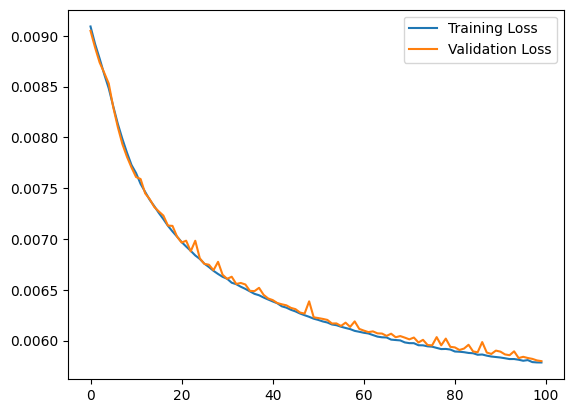

In [41]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend();

In [42]:
autoencoder.save(f"./models/modelCNNAutoEncoder-{100}")

INFO:tensorflow:Assets written to: ../models/modelCNNAutoEncoder-100/assets


INFO:tensorflow:Assets written to: ../models/modelCNNAutoEncoder-100/assets


## epochs=600

```
tensorboard --logdir=./data/autoencoder
```

In [89]:
del autoencoder

In [93]:
import datetime

log_dir = "../data/autoencoder/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

history = autoencoder.fit(x_train, x_train,
                epochs=600,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[tensorboard_callback, early_stopping])

Epoch 1/600


2022-10-24 14:49:05.408907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.0058

2022-10-24 14:49:14.527973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 10s 20ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 2/600
469/469 [==============================] - 9s 19ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 3/600
469/469 [==============================] - 9s 18ms/step - loss: 0.0058 - val_loss: 0.0058


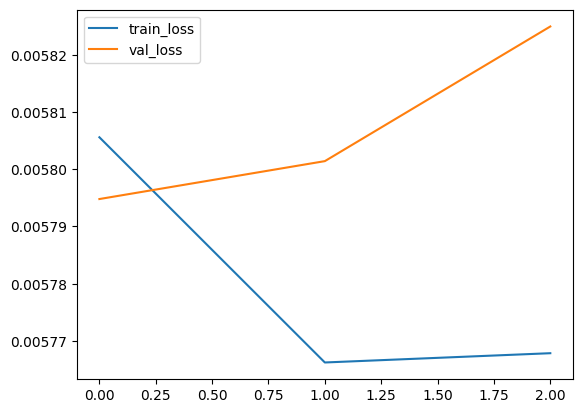

In [100]:
import pandas as pd

pd.DataFrame({
    'train_loss': history.history["loss"],
    'val_loss': history.history["val_loss"]
}).plot();

In [101]:
autoencoder.save(f"./models/modelCNNAutoEncoder-{600}.model")

INFO:tensorflow:Assets written to: ../models/modelCNNAutoEncoder-600.model/assets


INFO:tensorflow:Assets written to: ../models/modelCNNAutoEncoder-600.model/assets


 11/313 [>.............................] - ETA: 1s 

2022-10-24 14:54:02.880901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 4ms/step


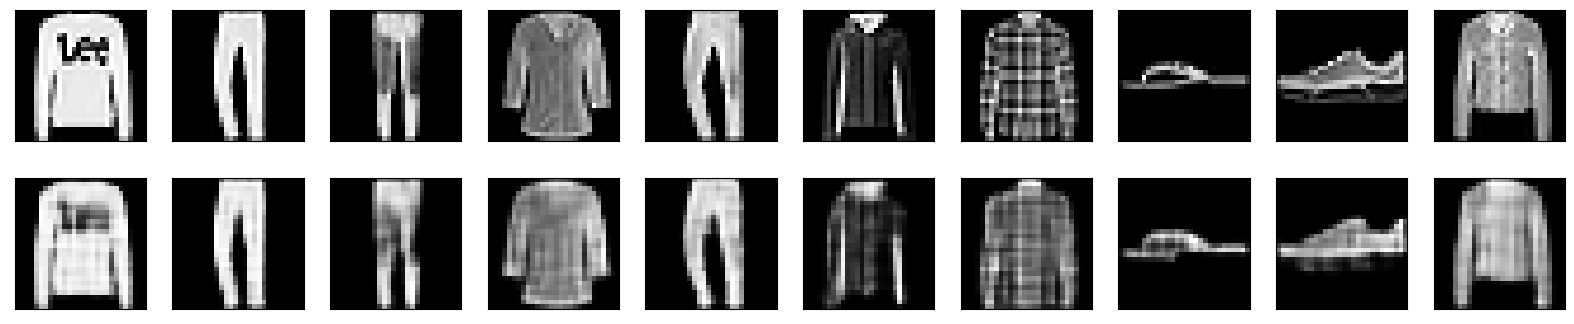

In [102]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28, 1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28, 1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()